## Using Pystan to fit Model 2. 
### Accessibility with Household and trancportation costs (% of income) with random intercepts and slopes

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo. Stan is useful in very high dimensional problems, where there are a large numbers of predictors to infer. In this instance we have over 16,000 rows of data so therefore using Stan's computationally efficient sampling strategies is appropriate.

In [1]:
%matplotlib inline
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import fiona
import seaborn as sns
#import libpysal
import pysal
#import mapclassify as mc
import shapely
from shapely.geometry import Point, Polygon, LineString
sns.set(style="ticks", palette="muted", color_codes=True)

pd.options.display.max_rows = 10

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Load in the Parameter dataset

In [3]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


Load in the spatial lag dataset

In [4]:
Lag_pred_for_merge = pd.read_csv('Lag_pred_for_merge.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Lag_pred_for_merge['GEOID10']=Lag_pred_for_merge['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Lag_pred_for_merge.head()

,Unnamed: 0,GEOID10,populati_1,yb,lag_ht_ami,lag_Lowest_Qui,lag_Hispanic,lag_Black_Afri,lag_White_Alon,lag_Less_high_,...,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,060371011101000,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,060371011101007,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,060371011101008,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,060371011101011,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,060371011102004,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


In [5]:
All_data = Data_clean_all_col.merge(Lag_pred_for_merge,
                                    on='GEOID10')
All_data.head()

,Unnamed: 0_x,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


We also need a lookup table (`list`) for each unique block, block group and tract, for indexing.

In [6]:
unique_blocks = All_data.BlockId.unique().tolist()
unique_bgs = All_data.BlockgroupId.unique().tolist()
unique_tracts = All_data.TractId.unique().tolist()

Then define the length of the lists for blocks, block groups and tracts. 

In [7]:
N = len(unique_blocks)
J = len(unique_bgs)
Q = len(unique_tracts)

### Partial pooling model

The simplest partial pooling model for the block Housing + Transportation Costs % Income dataset is one which simply estimates H+T Costs, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled block estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

- Estimates for blocks with smaller sample sizes will shrink towards the block group estimates.
- Estimates for blocks with larger sample sizes will be closer to the block group estimates.
    -   This results in two standard deviations, one describing the residual error of the observations, and another the variability of the block means around their block group average.

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

Do the *same* thing for each varying slope as you do with the varying intercept, but multiply the effect by the data that applies to it.


In [14]:
block_to_bg = dict(Data_clean_all_col[['BlockId', 'BlockgroupId']].values)

In [15]:
block_to_bg_vector = [unique_bgs.index(bg) + 1 for bg in block_to_bg.values()]

Then create a dictionary to summarise block group variability at the tract level.

In [16]:
bg_to_tract = dict(Data_clean_all_col[['BlockgroupId', 'TractId']].values)

In [17]:
bg_to_tract_vector = [unique_tracts.index(tract) + 1 for tract in bg_to_tract.values()]

Compute the average level of the parameters at each level.

In [18]:
bglevel = Data_clean_all_col.groupby('BlockgroupId')\
                            [['ht_ami']].apply(np.mean).values

As there is no greater heirarchical level than the tract, we summarise like this.

In [ ]:
tractlevel = np.zeros((Q,1))

In [ ]:
varying_intercept_slope = """
data {
  int<lower=0> N; 
  int<lower=0> P_N; 
  int<lower=0> J; 
  int<lower=0> P_J; 
  int<lower=0> Q; 
  int<lower=0> P_Q; 
  int<lower=1, upper=J> block_to_bg[N];
  int<lower=1, upper=Q> bg_to_tract[J];
  vector[J] ht_ami;
  vector[N] y;
} 
parameters {
  vector[J] bg_intercept;
  vector[Q] tract_intercept;
  real hypermean;
  vector[J] ht_ami_slope;
  real<lower=0> sigma_block;
  real<lower=0> sigma_bg;
  real<lower=0> sigma_tract;
}
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = bg_intercept[block_to_bg[i]] 
               + ht_ami[block_to_bg[i]] * ht_ami_slope[block_to_bg[i]];
    
}
model {
  for (j in 1:J)
    bg_intercept[j] ~ normal(tract_intercept[bg_to_tract[j]], sigma_bg);
  y ~ normal(y_hat, sigma_block);
}
"""

The first paragraph of the Stan model specifies the data: the number of blocks, $N$: the vector estimates, $y_1 ...y_j$; and the standard errors, $\sigma_1,... \sigma_j$. To specify this model in Stan, we begin by constructing the `data` block, which includes the estimated treatment effects of total travel time by private transportation in 10 minutes (`y`), the s.e. of effect estimates (`sigma`) as well as the number of samples (`N`). The data is constrained as  $N$ (the number of blocks) is constrained to be positive. 

The code next introduces the parameters: the unknowns to be estimated in the model fit. These are the block effects, $\theta_n$; the mean $\mu$, and the standard deviation, $\tau$, of the population of block effects, and the block-level errors $\eta$, and their effects $\theta$. In this model, we let $\theta$ be a transformation of $\mu$, $\tau$ and $\eta$ instead of directly declaring $\theta$ as a parameter. By parameterising this way the model sampler runs more efficiently; resulting in multivaiate geometry that can be fit better using a Hamiltonian Monte Carlo.

Finally, we model the `tot_r_10` measurements at the block level. In our model the distribution is the variance; Stan parameterises using the standard deviation. 

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

In [ ]:
data_for_model = dict(
    N = N,
    P_N = 1,
    J = J,
    P_J = 1,
    Q = Q,
    P_Q = 1,
    block_to_bg = block_to_bg_vector,
    ht_ami = bglevel.flatten(),
    y = Data_clean_all_col['Tot_r_10'].values
)

In [ ]:
sm2 = pystan.StanModel(model_code=varying_intercept_slope)
fit2 = sm2.sampling(data=data_for_model, 
                    iter=1000, 
                    chains=4, warmup=500, 
                    thin=1, seed=101)

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

In [6]:
import pickle
with open('./stanmodel_slopes_and_intercepts_model_2.pkl', 'wb') as outfile:
    pickle.dump(sm2, outfile)
with open('./stanmodel_slopes_and_intercepts_result_2.pkl', 'wb') as outfile:
    pickle.dump(fit2, outfile)

NameError: name 'sm2' is not defined

In [2]:
import pickle
with open('./Fit_2/stanmodel_slopes_and_intercepts_model.pkl', 'rb') as infile:
    sm_2 = pickle.load(infile)

In [3]:
with open('./Fit_2/stanmodel_slopes_and_intercepts_result.pkl', 'rb') as infile:
    fit_2 = pickle.load(infile)

In [ ]:
summary_dict = fit_2.summary()
fit2_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = fit1_df['mean']['alpha'], fit1_df['mean']['beta']

# Extracting traces
alpha = fit1['hypermean']
beta = fit1['beta']
sigma = fit1['sigma']
lp = fit1['lp__']
fit1_df.head()

In [4]:
summary_dict = fit_2.summary()
fit2_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
fit2_df.to_csv('./Fit_2/Predictions_IQR.csv')

In [ ]:


# Nice plot parameters
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#matplotlib.rc('text', usetex=True)

# Plotting regression line
x_min, x_max = 0, 220000
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.005 )

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(ht_ami, Tot_r_10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()

def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

plot_trace(alpha, 'alpha') 
plt.show()
plot_trace(beta, 'beta') 
plt.show()
plot_trace(sigma, 'sigma') 
plt.show()
plot_trace(lp, 'lp') 
plt.show()

In [41]:
pystan.stansummary(fit_2)

'Inference for Stan model: anon_model_4ef8d2c3a4bf4a176168c2ab8da79eee.\n4 chains, each with iter=1000; warmup=500; thin=1; \npost-warmup draws per chain=500, total post-warmup draws=2000.\n\n                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat\nbg_intercept[1]         4.42    2.98   5.53  -5.23   0.64   3.17   8.51   16.3      3   1.52\nbg_intercept[2]          4.4    2.98   5.46  -4.73   0.52    3.3   8.32  15.98      3   1.55\nbg_intercept[3]         4.33    2.97   5.48  -5.95   0.59   3.38   8.41  15.14      3   1.54\nbg_intercept[4]         4.21    2.94   5.47  -6.29   0.43    3.3   8.23  14.83      3   1.53\nbg_intercept[5]          4.2    2.97   5.38  -5.42   0.49   3.29   8.17  15.39      3   1.58\nbg_intercept[6]         4.24    2.98   5.59  -6.16   0.54   3.28    8.3  15.68      4    1.5\nbg_intercept[7]         4.19    2.95   5.45  -5.92   0.53   3.33   8.22  15.07      3   1.55\nbg_intercept[8]         4.28    2.99   5.39  -5.62   0.4

In [12]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain, ht_ami_chain = fit_2.extract(['sigma_block', 'sigma_bg', 'sigma_tract','ht_ami_slope']).values()

ValueError: No parameter ht_ami

In [11]:
sigma_b_full = sigma_b_chain.mean()
sigma_bg_full = sigma_bg_chain.mean()
sigma_t_full = sigma_t_chain.mean()
ht_ami_full = ht_ami_chain.mean()
print(ht_ami_full

2296.574748651251

In [ ]:
sigma_ht_ami_chain, sigma_bg_chain, sigma_t_chain = fit_2.extract(['sigma_block', 'sigma_bg', 'sigma_tract']).values()

In [5]:
sigma_b = sigma_b_chain[-500:].mean()
sigma_bg = sigma_bg_chain[-500:].mean()
sigma_t = sigma_t_chain[-500:].mean()

8873.58632542742

In [19]:
block_to_bg_dummies = pd.get_dummies(block_to_bg_vector).values
bg_to_tract_dummies = pd.get_dummies(bg_to_tract_vector).values

In [20]:
block_to_bg_dummies.shape

(16470, 3221)

In [21]:
from scipy import sparse

In [22]:
block_to_bg_sparse = sparse.csc_matrix(block_to_bg_dummies)
bg_to_tract_sparse = sparse.csc_matrix(bg_to_tract_dummies)

In [23]:
full_cov = sparse.identity(len(block_to_bg_vector)) * sigma_b**2 \
           + block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2

In [24]:
diag = full_cov.diagonal()

In [25]:
under_diag = diag**-.5

In [26]:
n = len(block_to_bg_vector)

In [27]:
full_correlation = sparse.identity(n).multiply(under_diag)\
                   @ (full_cov)\
                   @ sparse.identity(n).multiply(under_diag)

In [28]:
np.unique(full_correlation.data).round(10)

array([2.85e-08, 9.30e-08, 1.00e+00])

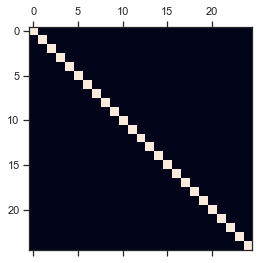

In [29]:
plt.matshow(full_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_2_bg.png')

# Disregarding block-level variation

In [30]:
partial_cov = block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2
           #+ sparse.identity(len(block_to_bg_vector)) * sigma_b \

In [31]:
partial_diag = partial_cov.diagonal() ** -.5

In [32]:
partial_correlation = sparse.identity(n).multiply(partial_diag)\
                       @ (partial_cov)\
                       @ sparse.identity(n).multiply(partial_diag)

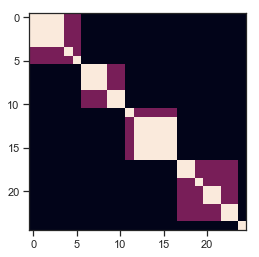

In [33]:
plt.imshow(partial_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_2_no_bg.png')

In [143]:
np.unique(partial_correlation.data)

array([0.3068032, 1.       ])

In [144]:
print(sigma_b**2, sigma_bg**2, sigma_t**2)

78740534.27481252 5.077781906535106 2.2473845371932155


In [ ]:
test_2 = fit2.to_dataframe()

In [ ]:
test_2.head()

In [ ]:
test_2.to_csv('./Stan_6000_fit2.csv')

In [ ]:
pred_2 = test_2.loc[:,'y_hat[1]':'y_hat[16470]']


In [ ]:
pred_2.to_csv('./Pred_6000_fit2.csv')

In [ ]:
pred_2000_2 = test_2.loc[1999:1999,'y_hat[1]':'y_hat[16470]']
pred_2000_2

In [ ]:
pred_trans_2 = pred_2000_2.transpose()

In [ ]:
pred_trans_2.to_csv('./Pred_6000_20000_trans_fit_2.csv')

# standardised results

In [32]:
predictions = pd.read_csv('./Fit_1/Pred_1_trans.csv')
predictions.head()

,Unnamed: 0,1999
0,y_hat[1],4.422776
1,y_hat[2],4.422776
2,y_hat[3],4.422776
3,y_hat[4],4.422776
4,y_hat[5],3.364825


In [33]:
y_pred = predictions['1999']
y_true = All_data['Tot_r_10']

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred)

102861.29910223311

In [35]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = check_array(y_true, y_pred)
return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


99.99770493469559

In [36]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [37]:
r2(y_pred, y_true)

-3.2305214784442793

In [38]:
predictions = pd.read_csv('./Fit_2/Pred_6000_20000_trans_fit_2.csv')
predictions.head()

,Unnamed: 0,1999
0,y_hat[1],14996.785691
1,y_hat[2],14996.785691
2,y_hat[3],14996.785691
3,y_hat[4],14996.785691
4,y_hat[5],30264.866235


In [39]:
y_pred = predictions['1999']
y_true = All_data['Tot_r_10']

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred)

5917.2058934397255

In [41]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = check_array(y_true, y_pred)
return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


8.051475212990498

In [42]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [43]:
r2(y_pred, y_true)

0.9759174350590746

In [29]:
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.9759159727623389

# Caterpillar plots

In [42]:
test = fit_2.to_dataframe('ht_ami_slope')

In [36]:
bg_stats = test.median().filter(like='ht_').to_frame('median')
bg_stats['top'] = test.quantile(.975).filter(like='ht_')
bg_stats['bottom'] = test.quantile(.025).filter(like='ht_')

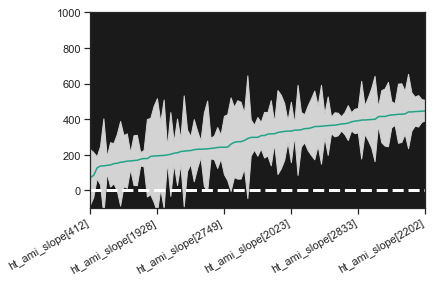

In [39]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
plt.gca().set_xlim(0,100)
plt.gca().set_ylim(-100,1000)
plt.savefig("fit_2_catterpillar_ht_ami_slope_zoom.png", format="PNG")

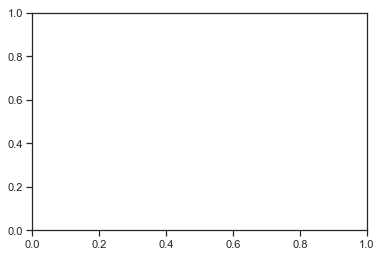

In [192]:
a = plt.gca()

In [ ]:
a.set_facecolor

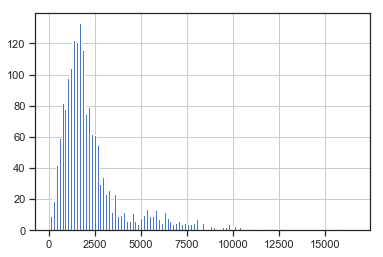

In [187]:
bg_stats['median'].hist(bins=200)

#### Plotting in Pystan

In [10]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=ht_ami_slope, whis=np.inf, color="c")
plt.savefig("ht_ami_ht_ami_slope_fit2.png", format="PNG")

NameError: name 'ht_ami_slope' is not defined

<Figure size 1152x432 with 0 Axes>

In [11]:
fit2.traceplot('ht_ami_slope')
plt.savefig("ht_ami_slope_fit_2.png", format="PNG")


NameError: name 'fit2' is not defined

KeyboardInterrupt: 

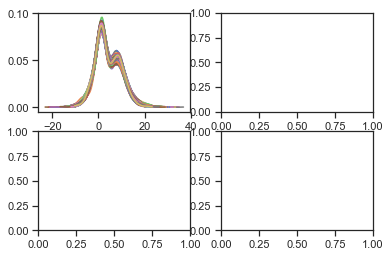

In [12]:
fit_2.plot(pars=['bg_intercept', 'ht_ami_slope']);
plt.savefig("bg_intercept_ht_ami_slope_fit2.png", format="PNG")

In [ ]:
fit2['bg_intercept'].mean()

The estimate for the `ht_ami` coefficient is approximately 4.2, which can be interpreted as houses with over 4% of their income being spent on household and transportation costs having about half the accessibility to employment by private transportation (after 10 mins of travel time) of those with less than 4% of income spent on housing and transportation, after accounting for the block.

In [13]:
fit_2['ht_ami_slope'].mean()

2296.574748651251

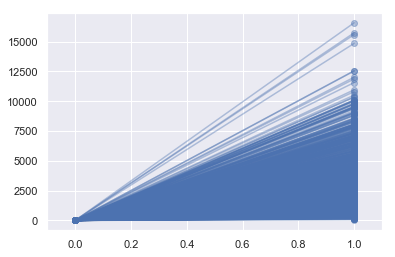

In [17]:
sns.set()
xvals = np.arange(2)
b = fit_2['tract_intercept'].mean(axis=0)
m = fit_2['ht_ami_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit2_tract.png", format="PNG")


#### Alpha
From the trace plot on top, we can see that the movement through parameter space resembles a random walk, which is indicative that the underlying Markov chain has reached convergence as we would hope. We can also take a look at the corresponding plots for beta and sigma.

#### Beta and Sigma
We can see from the plots of the posterior distributions that the ground truths are on the whole pretty close to the modes of our distributions, and comfortably within the 95% credible intervals. There is some bias between the peaks of the posteriors and the ground truths, which is introduced as a result of the noise in the data. The handy thing about the Bayesian approach is that the uncertainty in estimation is captured in the spread of these posteriors, and can be improved by providing more insightful priors.